## 导入及预处理

In [1]:
import pandas as pd
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = df[["text","sentiment"]]
test = test[["text","sentiment"]]
test['sentiment'].replace(["positive","neutral","negative"], [2,1,0], inplace=True)
df['sentiment'].replace(["positive","neutral","negative"], [2,1,0], inplace=True)
import string
import re
def process_raw_text(x):
    x = str(x).lower()
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('https?://\S+|www\.\S+', '', x)
    x = re.sub('<.*?>+', '', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x)
    x = re.sub('\n', '', x)
    x = re.sub('\w*\d\w*', '', x)
    x = x.strip()
    return x
df["text"] = df['text'].apply(lambda x:process_raw_text(x))
test["text"] = test['text'].apply(lambda x:process_raw_text(x))

## 向量化

In [3]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 9000)
tokenizer.fit_on_texts(df.text.values)
X_train = tokenizer.texts_to_sequences(df.text)
X_test =  tokenizer.texts_to_sequences(test.text)

In [4]:
from keras import preprocessing
maxlen = 20
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [5]:
import numpy as np
y_train = np.asarray(df.sentiment.tolist())
y_test = np.asarray(test.sentiment.tolist())
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

## 直接学习嵌入层

#### GRU

In [6]:
from keras.layers import *
from keras.models import  *
model = Sequential()
model.add(Embedding(9000, 64, input_length=maxlen))
model.add(GRU(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            576000    
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 585,987
Trainable params: 585,987
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))

Epoch 1/10
430/430 [==============================] - 7s 12ms/step - loss: 0.8373 - accuracy: 0.6095 - val_loss: 0.7047 - val_accuracy: 0.6958
Epoch 2/10
430/430 [==============================] - 5s 12ms/step - loss: 0.6148 - accuracy: 0.7476 - val_loss: 0.6701 - val_accuracy: 0.7136
Epoch 3/10
430/430 [==============================] - 7s 17ms/step - loss: 0.5196 - accuracy: 0.7944 - val_loss: 0.6923 - val_accuracy: 0.7122
Epoch 4/10
430/430 [==============================] - 7s 16ms/step - loss: 0.4484 - accuracy: 0.8261 - val_loss: 0.7452 - val_accuracy: 0.7077
Epoch 5/10
430/430 [==============================] - 6s 15ms/step - loss: 0.3885 - accuracy: 0.8519 - val_loss: 0.7792 - val_accuracy: 0.7026
Epoch 6/10
430/430 [==============================] - 6s 13ms/step - loss: 0.3327 - accuracy: 0.8746 - val_loss: 0.8582 - val_accuracy: 0.7006
Epoch 7/10
430/430 [==============================] - 5s 12ms/step - loss: 0.2874 - accuracy: 0.8937 - val_loss: 0.9432 - val_accuracy: 0.6890

In [43]:
acc_gru = history.history['accuracy']
val_gru = history.history['val_accuracy']

#### DNN

In [44]:
model = Sequential()
model.add(Embedding(10000, 64, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 20, 64)            640000    
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_23 (Dense)            (None, 64)                81984     
                                                                 
 dense_24 (Dense)            (None, 16)                1040      
                                                                 
 dense_25 (Dense)            (None, 3)                 51        
                                                                 
Total params: 723,075
Trainable params: 723,075
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_dnn = history.history['val_accuracy']

Epoch 1/10
430/430 [==============================] - 5s 10ms/step - loss: 0.8623 - accuracy: 0.5843 - val_loss: 0.6986 - val_accuracy: 0.6969
Epoch 2/10
430/430 [==============================] - 4s 10ms/step - loss: 0.5490 - accuracy: 0.7796 - val_loss: 0.7548 - val_accuracy: 0.6868
Epoch 3/10
430/430 [==============================] - 4s 9ms/step - loss: 0.3033 - accuracy: 0.8905 - val_loss: 0.9218 - val_accuracy: 0.6658
Epoch 4/10
430/430 [==============================] - 4s 9ms/step - loss: 0.1526 - accuracy: 0.9489 - val_loss: 1.1272 - val_accuracy: 0.6593
Epoch 5/10
430/430 [==============================] - 4s 9ms/step - loss: 0.0894 - accuracy: 0.9719 - val_loss: 1.3710 - val_accuracy: 0.6621
Epoch 6/10
430/430 [==============================] - 5s 11ms/step - loss: 0.0570 - accuracy: 0.9828 - val_loss: 1.5598 - val_accuracy: 0.6531
Epoch 7/10
430/430 [==============================] - 5s 12ms/step - loss: 0.0418 - accuracy: 0.9877 - val_loss: 1.8238 - val_accuracy: 0.6500
Ep

#### RNN

In [46]:
model = Sequential()
model.add(Embedding(9000, 64, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_rnn = history.history['val_accuracy']

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 20, 64)            576000    
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 3)                 51        
                                                                 
Total params: 579,683
Trainable params: 579,683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
430/430 [==============================] - 5s 9ms/step - loss: 0.9288 - accuracy: 0.5481 - val_loss: 0.7461 - val_accuracy: 0.6754
Epoch 2/10
430/430 [=================

#### LSTM

In [49]:
model = Sequential()
model.add(Embedding(9000, 64, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_lstm = history.history['val_accuracy']

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 20, 64)            576000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 3)                 51        
                                                                 
Total params: 588,995
Trainable params: 588,995
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
430/430 [==============================] - 9s 17ms/step - loss: 0.8296 - accuracy: 0.6124 - val_loss: 0.6918 - val_accuracy: 0.7015
Epoch 2/10
430/430 [================

## 预训练

In [7]:
# 此处载入GloVe的方法借鉴《Python深度学习》一书，并未做太多改动
import os
glove_dir = 'D:\Jupyter\projects\DL Projects\smmtwitter'

embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.100d.txt'), encoding="UTF-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [8]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((9000,100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < 9000:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

#### RNN

In [57]:
model = Sequential()
model.add(Embedding(9000, 100, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_rnn_pre = history.history['val_accuracy']

Epoch 1/10
430/430 [==============================] - 2s 4ms/step - loss: 1.0249 - accuracy: 0.4708 - val_loss: 0.9148 - val_accuracy: 0.5637
Epoch 2/10
430/430 [==============================] - 1s 3ms/step - loss: 0.8807 - accuracy: 0.5968 - val_loss: 0.9206 - val_accuracy: 0.5713
Epoch 3/10
430/430 [==============================] - 1s 3ms/step - loss: 0.8321 - accuracy: 0.6314 - val_loss: 0.8174 - val_accuracy: 0.6327
Epoch 4/10
430/430 [==============================] - 1s 3ms/step - loss: 0.8026 - accuracy: 0.6500 - val_loss: 0.8263 - val_accuracy: 0.6279
Epoch 5/10
430/430 [==============================] - 1s 3ms/step - loss: 0.7854 - accuracy: 0.6589 - val_loss: 0.7899 - val_accuracy: 0.6585
Epoch 6/10
430/430 [==============================] - 1s 3ms/step - loss: 0.7716 - accuracy: 0.6660 - val_loss: 0.7739 - val_accuracy: 0.6715
Epoch 7/10
430/430 [==============================] - 1s 3ms/step - loss: 0.7596 - accuracy: 0.6728 - val_loss: 0.7782 - val_accuracy: 0.6607
Epoch 

#### GRU

In [6]:
model = Sequential()
model.add(Embedding(9000, 100, input_length=maxlen))
model.add(GRU(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_gru_pre = history.history['val_accuracy']

#### LSTM

In [69]:
model = Sequential()
model.add(Embedding(9000, 100, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_lstm_pre = history.history['val_accuracy']

Epoch 1/10
430/430 [==============================] - 4s 7ms/step - loss: 0.9051 - accuracy: 0.5730 - val_loss: 0.7829 - val_accuracy: 0.6514
Epoch 2/10
430/430 [==============================] - 3s 7ms/step - loss: 0.7553 - accuracy: 0.6722 - val_loss: 0.7269 - val_accuracy: 0.6786
Epoch 3/10
430/430 [==============================] - 3s 7ms/step - loss: 0.7118 - accuracy: 0.6970 - val_loss: 0.7146 - val_accuracy: 0.6808
Epoch 4/10
430/430 [==============================] - 3s 8ms/step - loss: 0.6872 - accuracy: 0.7081 - val_loss: 0.6992 - val_accuracy: 0.6924
Epoch 5/10
430/430 [==============================] - 3s 7ms/step - loss: 0.6689 - accuracy: 0.7182 - val_loss: 0.6838 - val_accuracy: 0.7046
Epoch 6/10
430/430 [==============================] - 3s 7ms/step - loss: 0.6530 - accuracy: 0.7254 - val_loss: 0.6826 - val_accuracy: 0.7018
Epoch 7/10
430/430 [==============================] - 3s 8ms/step - loss: 0.6384 - accuracy: 0.7345 - val_loss: 0.6786 - val_accuracy: 0.7102
Epoch 

#### DNN

In [70]:
model = Sequential()
model.add(Embedding(9000, 100, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data = (X_test,y_test))
val_dnn_pre = history.history['val_accuracy']

Epoch 1/10
430/430 [==============================] - 1s 2ms/step - loss: 0.9509 - accuracy: 0.5343 - val_loss: 0.9035 - val_accuracy: 0.5668
Epoch 2/10
430/430 [==============================] - 1s 2ms/step - loss: 0.8239 - accuracy: 0.6214 - val_loss: 0.8791 - val_accuracy: 0.5934
Epoch 3/10
430/430 [==============================] - 1s 2ms/step - loss: 0.7627 - accuracy: 0.6606 - val_loss: 0.8695 - val_accuracy: 0.5942
Epoch 4/10
430/430 [==============================] - 1s 2ms/step - loss: 0.7026 - accuracy: 0.6934 - val_loss: 0.8944 - val_accuracy: 0.5951
Epoch 5/10
430/430 [==============================] - 1s 2ms/step - loss: 0.6355 - accuracy: 0.7294 - val_loss: 0.9261 - val_accuracy: 0.5826
Epoch 6/10
430/430 [==============================] - 1s 2ms/step - loss: 0.5626 - accuracy: 0.7669 - val_loss: 0.9854 - val_accuracy: 0.5815
Epoch 7/10
430/430 [==============================] - 1s 2ms/step - loss: 0.4802 - accuracy: 0.8080 - val_loss: 1.0522 - val_accuracy: 0.5716
Epoch 

## 模型对比结果可视化（这一栏的输出不小心被我清空了）

In [7]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize = (15,8))
plt.ylim(0.5,0.73)
plt.plot(epochs, val_gru,marker='o' ,label='GRU')
plt.plot(epochs, val_dnn, marker='o' ,label='DNN')
plt.plot(epochs, val_rnn, marker='o' ,label='RNN')
plt.plot(epochs, val_lstm,marker='o' , label='LSTM')
plt.plot(epochs, val_rnn_pre, marker='o' ,linestyle="dashed" ,  label='RNN_pre')
plt.plot(epochs, val_gru_pre,marker='o' , linestyle="dashed" , label='GRU_pre')
plt.plot(epochs, val_lstm_pre, marker='o' , linestyle="dashed" , label='LSTM_pre')
plt.plot(epochs, val_dnn_pre, marker='o',linestyle="dashed" , label='DNN_pre')
plt.xlabel("Epochs")
plt.ylabel("Accuracy on Test Dataset")
plt.legend(loc = "lower left")
plt.savefig('4.png')

## 序列长度统计可视化

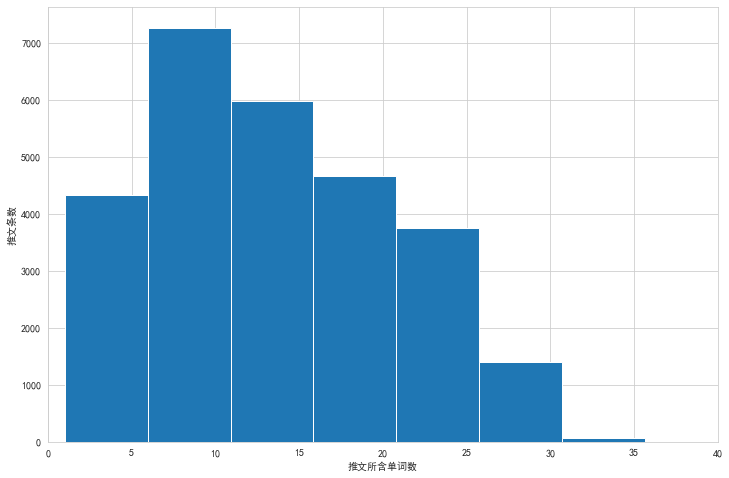

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
lens = []
for x in df.text:
    y = len(x.split(" "))
    lens.append(y)
plt.xlabel("推文所含单词数")
plt.ylabel("推文条数")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.xlim(0,40)
plt.hist(lens,bins=20)
plt.savefig('4.png')